# Step 1. Download and view the data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
%matplotlib inline

In [2]:
#Create a connection to database
con=sqlite3.connect('Data/attrition.db')

In [3]:
# Get the table names in Database
def sql_fetch(con):
    cursorObj = con.cursor()
    cursorObj.execute('SELECT name from sqlite_master where type= "table"')
    print(cursorObj.fetchall())
sql_fetch(con)

[('attrition',), ('projects',)]


In [4]:
# Read the data
df = pd.read_sql_query("SELECT * FROM attrition", con)

In [5]:
df.head()

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Usage Rate,Branch,Membership,Months,Birth Year,Usage Time
0,1d172e75-2c13-4b73-a1da-18d442a10bf7,1,41,Female,5993,0.2 hours,Diploma,Engineering,2,Changi,Gold,7,1981,7
1,6dee0995-9ff1-44a6-b3f1-fc5f7270c8ab,0,49,Male,5130,0.7 hours,Diploma,Engineering,3,Thomson,Normal,11,1973,2
2,c9fff882-42e7-4e12-88ab-74aba95113dc,1,37,Male,2090,20.0 mins,Diploma,Medical,4,Thomson,Normal,1,1985,2
3,1521db93-82d8-46a8-9718-6acde2a7c001,0,33,Female,2909,20.0 mins,Master,Engineering,4,Thomson,Normal,9,1989,0
4,e8a69be8-c96a-4f37-b14c-b3c75aa32db3,0,27,Male,3468,0.3 hours,Diploma,Information Technology,1,Thomson,Normal,3,1995,15


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Member Unique ID  2470 non-null   object
 1   Attrition         2470 non-null   int64 
 2   Age               2470 non-null   int64 
 3   Gender            2470 non-null   object
 4   Monthly Income    2470 non-null   int64 
 5   Travel Time       2470 non-null   object
 6   Qualification     2470 non-null   object
 7   Work Domain       2470 non-null   object
 8   Usage Rate        2470 non-null   int64 
 9   Branch            2470 non-null   object
 10  Membership        2470 non-null   object
 11  Months            2470 non-null   int64 
 12  Birth Year        2470 non-null   int64 
 13  Usage Time        2470 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 270.3+ KB


In [7]:
df.describe()

,Attrition,Age,Monthly Income,Usage Rate,Months,Birth Year,Usage Time
count,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000,2470.000000
mean,0.169636,35.970850,5143.199595,2.780972,10.634413,1734.040486,4.846964
std,0.375388,16.757217,6542.273046,1.033757,9.225734,655.077597,3.925911
min,0.000000,-1.000000,-24620.000000,1.000000,0.000000,-1.000000,0.000000
25%,0.000000,29.000000,2610.000000,2.000000,5.000000,1969.000000,2.000000
50%,0.000000,38.000000,4785.000000,3.000000,8.000000,1980.000000,4.000000
75%,0.000000,48.000000,7981.750000,4.000000,13.000000,1988.000000,6.000000
max,1.000000,69.000000,25326.000000,4.000000,57.000000,2004.000000,20.000000


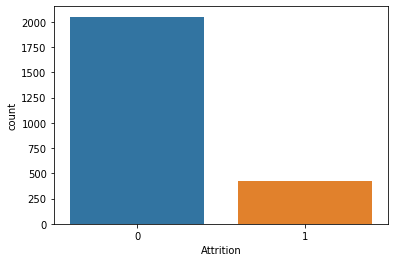

In [8]:
# Check the Attrition values
sns.countplot(df['Attrition'])

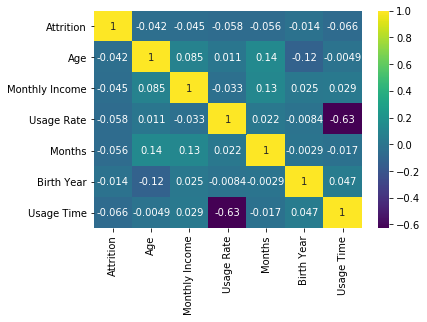

In [9]:
sns.heatmap(df.corr(),cmap='viridis',annot=True)

# Step 2. Preprocess the Data

## 2.1 Deal with the highly correlated columns: 'Usage Rate' and 'Usage Time'

In [10]:
# 'Usage Rate' is "Average number of days in a week visiting the country club"
# 'Usage Time' is "Average number of hours spent in the country club per visit"

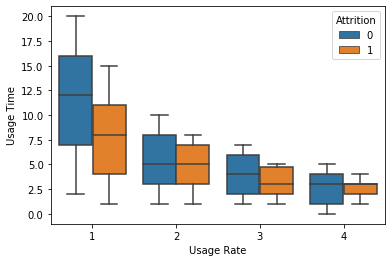

In [11]:
sns.boxplot(x='Usage Rate', y='Usage Time',data= df, hue='Attrition')

In [12]:
df.groupby('Usage Rate').mean()['Attrition']

Usage Rate
1    0.230769
2    0.152401
3    0.169875
4    0.147632
Name: Attrition, dtype: float64

In [13]:
# I will combine 'Usage Rate' and Usage Time' columns, to generate a new column "Time Per Week" (Usage Rate* Usage Time)

In [14]:
df['Hours per Week']=df['Usage Time']*df['Usage Rate']

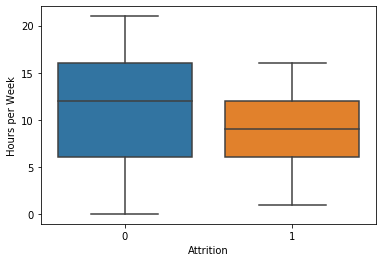

In [15]:
sns.boxplot(x='Attrition', y='Hours per Week', data=df)

In [16]:
df.groupby('Attrition').mean()

,Age,Monthly Income,Usage Rate,Months,Birth Year,Usage Time,Hours per Week
Attrition,,,,,,,
0,36.292540,5276.349098,2.807899,10.867382,1738.294490,4.964895,11.269625
1,34.396181,4491.434368,2.649165,9.494033,1713.217184,4.269690,9.286396


### Conclusions: 
1. Customers that go to the club just once a week has evident higher Attrition rate (23%) than those go 2-4 times a week (15%-17%)
2. Customers tend to spend less hours per visit if they visit more times per week.
3. The customers choose Attrition on average spend 2 hours less per week in the club

## 2.2 Convert the 'Travel Time' column with inconsistent units 

In [17]:
df['Travel Time'].value_counts()

0.7 hours                  269
0.3 hours                  193
0.8 hours                  192
0.5 hours                  182
40.0 mins                  180
                          ... 
22.19135153941856 mins       1
22.59821606032108 mins       1
53.75233599748068 mins       1
22.130819113071446 mins      1
21.88522209192417 mins       1
Name: Travel Time, Length: 525, dtype: int64

In [18]:
# create a function to convert the 'Travel Time' from string with different units to numerical values in mins 
def cal_travel_time(x):
    if x.split()[1]=='mins':
        return int(float(x.split()[0]))
    else:
        return int(float(x.split()[0])*60)

In [19]:
# Apply the function cal_travel_time to column
df['Travel Time']=df['Travel Time'].apply(lambda x: cal_travel_time(x))

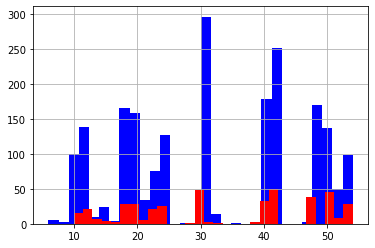

In [90]:
df[df['Attrition']==0]['Travel Time'].hist(bins=30,label='Attrition 0',color='blue')
df[df['Attrition']==1]['Travel Time'].hist(bins=30,label='Attrition 1',color='red')

In [21]:
df.groupby('Branch').mean()['Travel Time']

Branch
Changi     32.251918
Kranji     32.812950
Thomson    31.943835
Name: Travel Time, dtype: float64

In [22]:
# The 'Travel Time is not continuous, and peak around 10, 20, 30, 40, and 50', will tranform it to categorical data
bins = [0, 15, 25, 35, 45, np.inf]
names = ['<15', '15-25', '25-35', '35-45', '>45']

df['Travel Time_cat'] = pd.cut(df['Travel Time'], bins, labels=names)

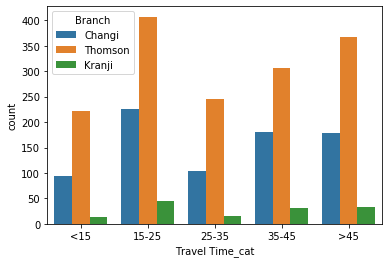

In [23]:
sns.countplot(x='Travel Time_cat', data=df, hue='Branch')

In [24]:
df.groupby('Travel Time_cat').mean()[['Attrition']]

,Attrition
Travel Time_cat,
<15,0.145455
15-25,0.163959
25-35,0.147945
35-45,0.162162
>45,0.210345


### Conclusions: 
1. Customers that have travel time more than 45 mins show a higher Attrition Rate (21%) than those with Travel time less than 45 mins (15%-16%)
2. On average, customers have tranvel time around 30 mins to all the three club branchs


## 2.3 Deal with invalid negative value in 'Monthly Income' columns

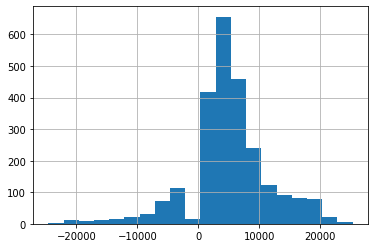

In [25]:
df['Monthly Income'].hist(bins=20)

In [26]:
((df['Monthly Income']<0).sum())/len(df)

0.12105263157894737

In [27]:
# Thers are 12% of values with negative monthly incomes, 
# The distributin of negative monthly income looks mirror (although much smaller amount) the positive values
# We check the Attrtion rates in negative and positive monthly income groups

In [28]:
Negative_income=df[df['Monthly Income']<0][['Attrition']]
Negative_income_Attrition_Rate=Negative_income.sum()/len(Negative_income)
Negative_income_Attrition_Rate

Attrition    0.170569
dtype: float64

In [29]:
Positive_income=df[df['Monthly Income']>0][['Attrition']]
Positive_income_Attrition_Rate=Positive_income.sum()/len(Positive_income)
Positive_income_Attrition_Rate

Attrition    0.169507
dtype: float64

In [30]:
# The two attrition rates are very close, thus reasonable to convert the negative monthly incomes into positive ones

In [31]:
df['Monthly Income']=abs(df['Monthly Income'])

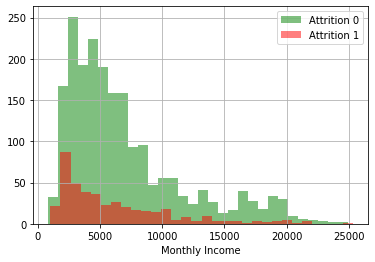

In [32]:
df[df['Attrition']==0]['Monthly Income'].hist(bins=30, color='green', label= 'Attrition 0', alpha=0.5)
df[df['Attrition']==1]['Monthly Income'].hist(bins=30,color='red', label= 'Attrition 1',alpha=0.5)
plt.xlabel('Monthly Income')
plt.legend()

In [33]:
df.groupby('Attrition').mean()['Monthly Income']

Attrition
0    7005.297903
1    6015.157518
Name: Monthly Income, dtype: float64

### Condlusion
1. Customers opt to Attrition has SGD 1k less monthly income than those who keep the membership.

## 2.4 Deal with negative value (-1) in 'Age' and 'Birth Year' columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E43C73E188>,
      dtype=object)

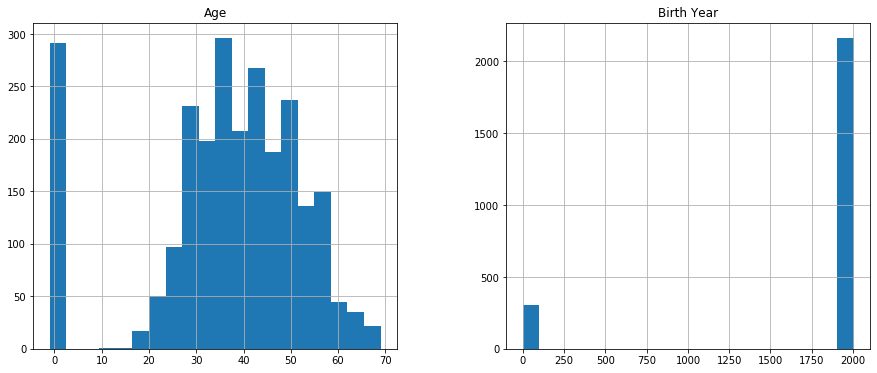

In [34]:
df[['Age','Birth Year']].hist(figsize=(15,6),bins=20)

In [35]:
#Calculate the Number of rows with both negative 'Age' and negative 'Birth Year' values
and_neg= len(df[(df['Age']<0) & (df['Birth Year']<0 )])
and_neg

0

In [36]:
#Calculate the Number of rows with either negative 'Age' or negative 'Birth Year' values
or_neg= len(df[(df['Age']<0) | (df['Birth Year']<0 )])
or_neg

599

In [37]:
#Calculate the Number of rows with negative 'Age' values
len(df[df['Age']<0])

291

In [38]:
#Calculate the Number of rows with negative 'Birth Year' values
len(df[df['Birth Year']<0])

308

In [39]:
# It is observed that there are 291 invalid 'Age' values, 308 invalid 'Birth Year' values
# Luckily every data entry has at least one valid 'Age' or valid 'Birth Year' values
# Next I will try to fill the invalid 'Age' values with estimated age values

In [40]:
# Explore relationship between 'Age', 'Birth Year' and 'Months' based on rows with valid positive values

In [41]:
Age_Birth=df[(df['Age']>0) & (df['Birth Year']>0)][['Age','Birth Year']]

In [42]:
Age_Birth['Current_Year']= Age_Birth['Age']+Age_Birth['Birth Year']
Age_Birth['Current_Year'].value_counts()

2022    1871
Name: Current_Year, dtype: int64

In [43]:
# Therefore, calculate 'Age'=2022-'Birth Year' for invalid age values;
# This indicates that database is for customers who signed up membership this year.

In [44]:
df['Age']=np.where(df['Age']>0, df['Age'], (2022-df['Birth Year']))

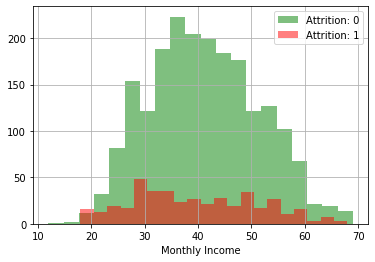

In [45]:
df[df['Attrition']==0]['Age'].hist(bins=20, color='green', label= 'Attrition: 0', alpha=0.5)
df[df['Attrition']==1]['Age'].hist(bins=20,color='red', label= 'Attrition: 1',alpha=0.5)
plt.xlabel('Monthly Income')
plt.legend()

In [46]:
df.groupby('Attrition').mean()['Age']

Attrition
0    41.133106
1    39.257757
Name: Age, dtype: float64

In [47]:
df.drop('Birth Year', axis=1, inplace=True)

### Conclusion
1. For the two groups, members opt to Attrition are slightly younger than those keep membership, although the age difference is not much.

## 2.4 Convert the Qualification column

In [48]:
df['Qualification'].value_counts()

Bachelor                891
Diploma                 765
Master                  641
Ph.D                    100
Bachelor's               41
Master's                 27
Doctor of Philosophy      5
Name: Qualification, dtype: int64

In [49]:
# convert Bacheloar's into Bachelor; Convert 'Master's' into 'Master'; Convert "Doctor of Philosophy" to "Ph.D"
df['Qualification']=df['Qualification'].map(
    {'Bachelor':'Bachelor',
     'Master':'Master',
     'Ph.D':'Ph.D',
     'Diploma':'Diploma',
    
    "Bachelor's":'Bachelor',
     "Master's":'Master',
     'Doctor of Philosophy':'Ph.D'})

In [50]:
df['Qualification'].value_counts()

Bachelor    932
Diploma     765
Master      668
Ph.D        105
Name: Qualification, dtype: int64

In [51]:
df.groupby(['Qualification','Gender']).mean()[['Attrition']]

Attrition
Qualification Gender           
Bachelor      Female   0.164894
              Male     0.174460
Diploma       Female   0.180952
              Male     0.191111
Master        Female   0.140741
              Male     0.165829
Ph.D          Female   0.061224
              Male     0.178571

### Conclusion:
1. The higher degree the female members hold, the less likely they choose Attrition; For male members, attrition rate does not change evidently with qualification;

## 2.5 Check other object columns¶

In [52]:
# Object types: Work Domain, Branch, Membership, Gender
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Member Unique ID  2470 non-null   object  
 1   Attrition         2470 non-null   int64   
 2   Age               2470 non-null   int64   
 3   Gender            2470 non-null   object  
 4   Monthly Income    2470 non-null   int64   
 5   Travel Time       2470 non-null   int64   
 6   Qualification     2470 non-null   object  
 7   Work Domain       2470 non-null   object  
 8   Usage Rate        2470 non-null   int64   
 9   Branch            2470 non-null   object  
 10  Membership        2470 non-null   object  
 11  Months            2470 non-null   int64   
 12  Usage Time        2470 non-null   int64   
 13  Hours per Week    2470 non-null   int64   
 14  Travel Time_cat   2470 non-null   category
dtypes: category(1), int64(8), object(6)
memory usage: 272.9+ KB


### 2.5.1 Check 'Work Domain'

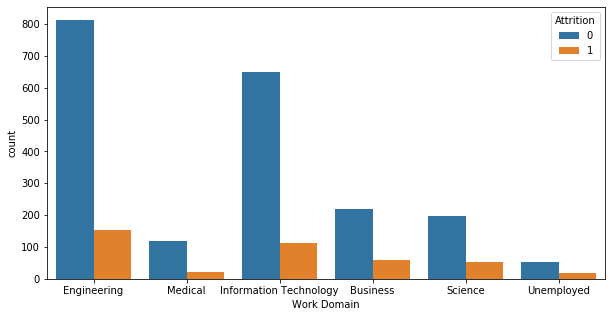

In [53]:
plt.figure(figsize=(10,5))
sns.countplot(x='Work Domain',hue='Attrition', data=df)

In [54]:
df.groupby(['Work Domain']).mean()[['Attrition']]

,Attrition
Work Domain,
Business,0.212996
Engineering,0.158385
Information Technology,0.149020
Medical,0.154930
Science,0.209677
Unemployed,0.263889


In [55]:
df.groupby(['Work Domain','Gender']).mean()[['Attrition']]

Attrition
Work Domain            Gender           
Business               Female   0.228070
                       Male     0.202454
Engineering            Female   0.156410
                       Male     0.159722
Information Technology Female   0.132075
                       Male     0.161074
Medical                Female   0.076923
                       Male     0.200000
Science                Female   0.184211
                       Male     0.231343
Unemployed             Female   0.272727
                       Male     0.260000

### Conclusion:
1. Unemployed members have the highest attrition rate (26%), followed by Business and Science (21%), and the lowest are Engineering, Medical and Information Technology (~15%)

### 2.5.2 Check 'Branch'

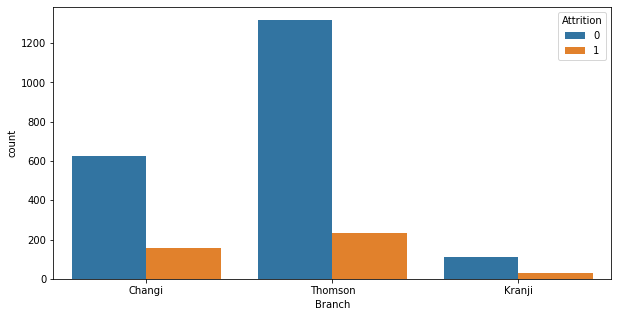

In [56]:
plt.figure(figsize=(10,5))
sns.countplot(x='Branch',hue='Attrition', data=df)

In [57]:
df.groupby(['Branch','Gender']).mean()[['Attrition']]

Attrition
Branch  Gender           
Changi  Female   0.206897
        Male     0.200461
Kranji  Female   0.297872
        Male     0.163043
Thomson Female   0.120325
        Male     0.168094

In [58]:
df.groupby(['Branch']).mean()

,Attrition,Age,Monthly Income,Travel Time,Usage Rate,Months,Usage Time,Hours per Week
Branch,,,,,,,,
Changi,0.203325,40.820972,7150.640665,32.251918,2.718670,11.314578,4.980818,11.048593
Kranji,0.208633,42.287770,7031.561151,32.812950,2.776978,11.258993,4.654676,10.755396
Thomson,0.149128,40.679793,6661.735959,31.943835,2.812782,10.234990,4.796643,10.890897


### Conclusion: 
1. Thomson Branch show the 5% less attrition rate than the other two branchs (Changi and Krangi), despite that its members have lower average monthly income
2. Krangi has much higher attrition rate among female members than male memebers

### 2.5.3 Check 'Membership'

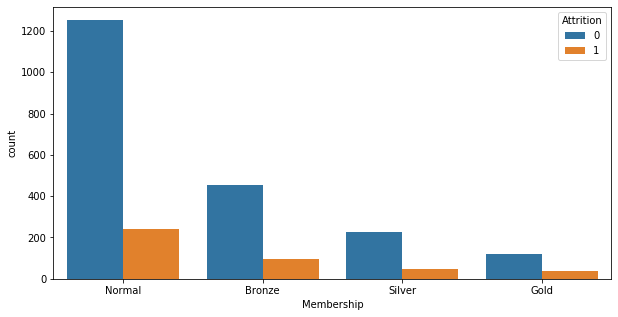

In [59]:
plt.figure(figsize=(10,5))
sns.countplot(x='Membership',hue='Attrition', data=df,order=['Normal','Bronze','Silver','Gold'])

In [60]:
df.groupby(['Membership']).mean()

,Attrition,Age,Monthly Income,Travel Time,Usage Rate,Months,Usage Time,Hours per Week
Membership,,,,,,,,
Bronze,0.175182,40.812044,6585.934307,32.072993,2.750000,10.538321,4.954380,11.160584
Gold,0.237179,41.448718,6880.634615,31.916667,2.762821,11.089744,4.846154,10.756410
Normal,0.160188,40.745308,6935.182976,32.306971,2.794236,10.560992,4.876676,11.016086
Silver,0.171533,40.839416,6782.675182,31.043796,2.781022,10.967153,4.470803,10.127737


### Conclusion:
1. The Attrition rate in general increses with high-tier of Membership from 16% (Normal), 17% (Bronze and Silver) to 24% (Gold)

### 2.3.4 Check "Gender"

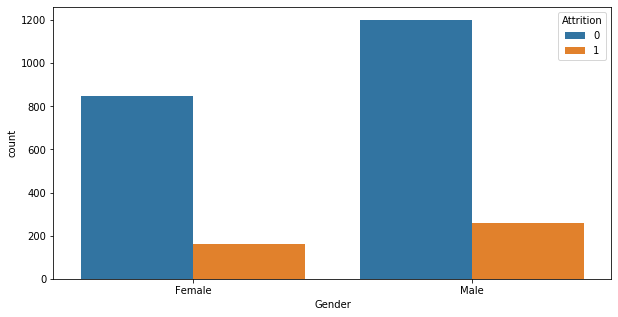

In [61]:
plt.figure(figsize=(10,5))
sns.countplot(x='Gender',hue='Attrition', data=df)

In [62]:
df.groupby(['Gender']).mean()

,Attrition,Age,Monthly Income,Travel Time,Usage Rate,Months,Usage Time,Hours per Week
Gender,,,,,,,,
Female,0.158416,41.396040,6839.001980,31.696040,2.779208,10.968317,4.893069,10.985149
Male,0.177397,40.413014,6836.181507,32.363014,2.782192,10.403425,4.815068,10.897260


### Conclusion:
1. Female show slightly lower Attrition rate than their Male counterparts

# 3. Insights from EDA

### 17% of club members opt for attrition.This is critical to business because it is often more expensive to acquire new customers than to keep existing ones.

In general, attrition rate is positively correlated to travel time, but negatively correlated to member's age, monthly income, hours spent in the club,  and number of months as a member.

Text(0.5, 1.0, 'Attrition rate of 17%')

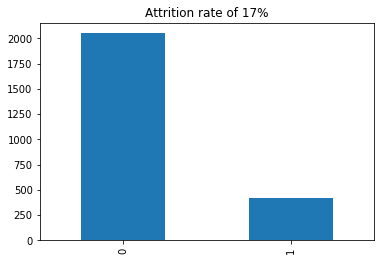

In [82]:
df['Attrition'].value_counts().plot(kind='bar').set_title('Attrition rate of 17%')

In [81]:
df['Attrition'].sum()/len(df)

0.16963562753036437

### 3.1  On average, members who opt for attrition spend 9.3 hours in the country club, it is 2 hours less than those who keep the membership

In [64]:
df.groupby('Attrition').mean()[['Hours per Week']]

,Hours per Week
Attrition,
0,11.269625
1,9.286396


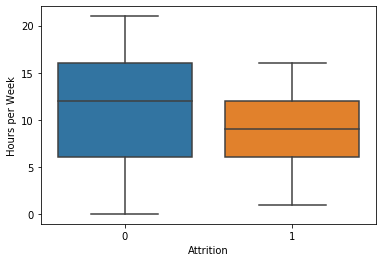

In [65]:
sns.boxplot(x='Attrition', y='Hours per Week',data=df)

### 3.2 Memberes who opt for attrition earn sgd 6000 monthly on average, which is sgd 1000 less than those who keep membership 

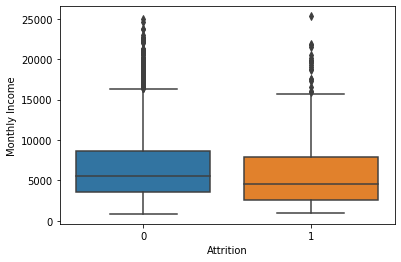

In [66]:
sns.boxplot(x='Attrition', y='Monthly Income',data=df)

### 3.3 Unemployed members have the highest attrition rate (26%), followed by Business and Science (21%). Members in Engineering, Medical and Information Technology show the lowest attrition rate (~15%)

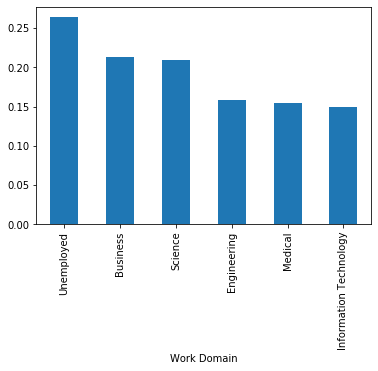

In [67]:
df.groupby('Work Domain').mean()['Attrition'].sort_values(ascending=False).plot(kind='bar')

### 3.4 Among three branches, Thomson Branch has the lowest attrition rate of 15%, which is 5% less than the other two branchs (Changi and Krangi), despite that Thomson Branch has the most memebers and lowest average monthly income.

### For female members, Krangi has the higheast attrition rate (30%), while Thomson has the lowest (12%).

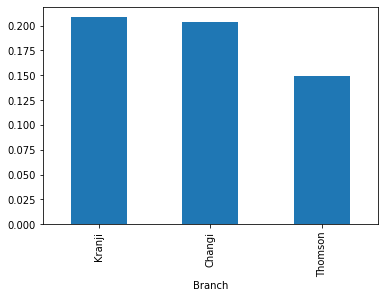

In [83]:
df.groupby('Branch').mean()['Attrition'].sort_values(ascending=False).plot(kind='bar')

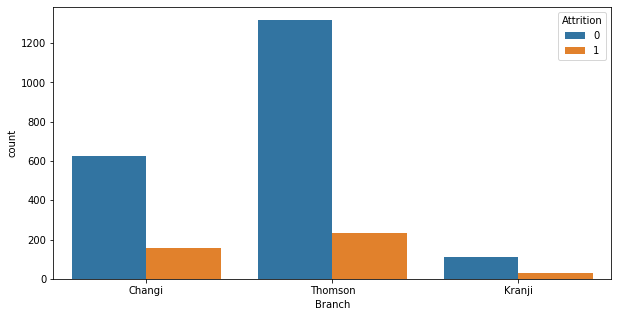

In [84]:
plt.figure(figsize=(10,5))
sns.countplot(x='Branch',hue='Attrition', data=df)

(6000, 7500)

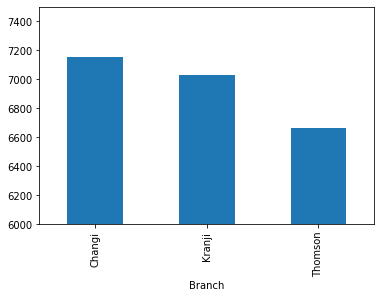

In [69]:
df.groupby('Branch').mean()['Monthly Income'].sort_values(ascending=False).plot(kind='bar')
plt.ylim(6000,7500)

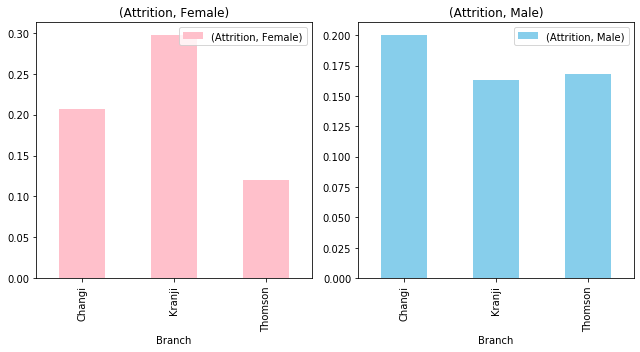

In [70]:
Gender_Branch=df.groupby(['Gender','Branch']).mean()[['Attrition']]
ax = Gender_Branch.unstack(level=0).plot(kind='bar', color=['Pink','Skyblue'],subplots=True, figsize=(9, 5), layout=(1, 2))
plt.tight_layout()

### 3.5 Members with travel time > 45 mins show a higher Attrition Rate (21%) than those with Travel time < 45 mins (15%-16%). The average travel time needed for members is around 30 mins for all 3 branches.

In [71]:
df.groupby(['Travel Time_cat']).mean()['Attrition']

Travel Time_cat
<15      0.145455
15-25    0.163959
25-35    0.147945
35-45    0.162162
>45      0.210345
Name: Attrition, dtype: float64

In [72]:
df.groupby(['Branch']).mean()['Travel Time']

Branch
Changi     32.251918
Kranji     32.812950
Thomson    31.943835
Name: Travel Time, dtype: float64

### 3.6 Members holding higher qualifications tends to have lower attrition rates: 12% (Ph.D), 16% (Master), 17%  (Bachelor) and 19% (Diploma). This trend is more evident among female members than their male counterparts.

In [73]:
df.groupby(['Qualification']).mean()[['Attrition']].loc[['Diploma','Bachelor','Master','Ph.D']]

,Attrition
Qualification,
Diploma,0.186928
Bachelor,0.170601
Master,0.155689
Ph.D,0.123810


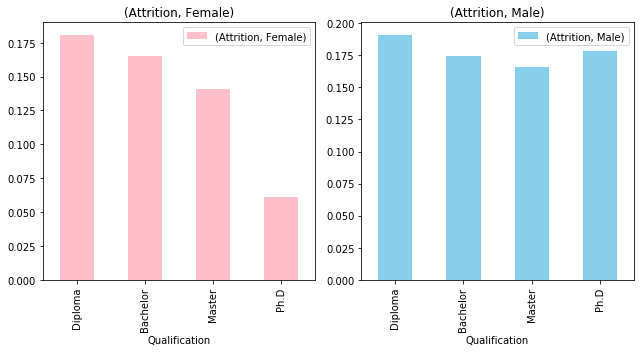

In [74]:
Qua =df.groupby(['Gender','Qualification']).mean()[['Attrition']]
ax = Qua.unstack(level=0).loc[['Diploma','Bachelor','Master','Ph.D']].plot(kind='bar', color=['Pink','Skyblue'], subplots=True, figsize=(9, 5), layout=(1, 2))
plt.tight_layout()

### 3.7 Members with higher-tier membership show higher attrition rate, compared to those with lower ones. This trend is more evident among female members.

In [75]:
df.groupby(['Membership']).mean()[['Attrition']].loc[['Normal','Bronze','Silver','Gold']]

,Attrition
Membership,
Normal,0.160188
Bronze,0.175182
Silver,0.171533
Gold,0.237179


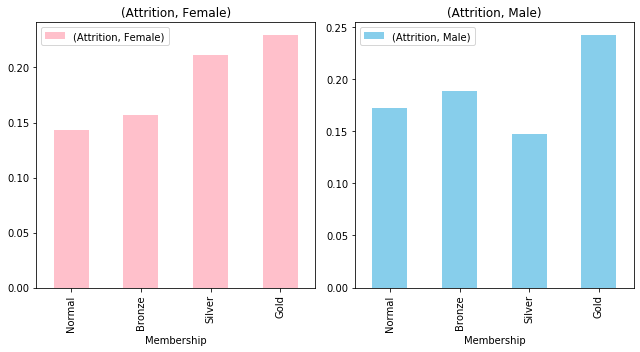

In [76]:
Qua =df.groupby(['Gender','Membership']).mean()[['Attrition']]
ax = Qua.unstack(level=0).loc[['Normal','Bronze','Silver','Gold']].plot(kind='bar', subplots=True,color=['Pink','Skyblue'], figsize=(9, 5), layout=(1, 2))
plt.tight_layout()

## Completed!